# Import Packages

In [1]:
import os
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/mpingol/ .cache'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sentence_transformers import SentenceTransformer, util
from automl_prec import AutoML
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from ctfidf import CTFIDFVectorizer

# Load Data

In [3]:
df = pd.read_excel('research_profile_v5.xlsx')

# Create a Corpus

In [4]:
sdg_df = df[['Research Title', 'Abstract', 'Keywords', 'SDG']].copy()
sdg_df.columns = ['title', 'abstract', 'keywords', 'sdg']

sdg_df['keywords'].fillna("", inplace=True)
sdg_df['abstract'].fillna("", inplace=True)

# create corpus
sdg_df['corpus'] = None
for idx in sdg_df.index:
    try:
        sdg_df['corpus'].loc[idx] = (sdg_df['title'].loc[idx] + sdg_df['abstract'].loc[idx] + sdg_df['keywords'].loc[idx])
    except:
        continue
        
sdg_pred = sdg_df[sdg_df['sdg'].isnull()].index
sdg_idx = sdg_df[(sdg_df['sdg'].notnull())].index

sdg_df = sdg_df[['corpus', 'sdg']].loc[sdg_idx].copy()

## Turn Multi-Label into Single-Label

In [5]:
sdg_df['sdg_type'] = sdg_df['sdg'].apply(lambda x: type(x))

#display(sdg_df['sdg'].apply(lambda x: type(x)).value_counts())

# random choice
#for idx in sdg_df[sdg_df['sdg_type'] == str].index:
#    sdg_df['sdg'].loc[idx] = np.random.choice(sdg_df['sdg'].loc[idx].split(';'))

# smaller counts
for idx in sdg_df[sdg_df['sdg_type'] == str].index:
    multi_label = [int(i) for i in sdg_df['sdg'].loc[idx].split(';')]
    label_counts = [sdg_df['sdg'].value_counts().loc[label] for label in multi_label]
    sdg_df['sdg'].loc[idx] = multi_label[np.argmin(label_counts)]
    
sdg_df = sdg_df.drop('sdg_type', axis=1)
sdg_df['sdg'] = sdg_df['sdg'].astype(int)

#display(sdg_df['sdg'].apply(lambda x: type(x)).value_counts())

## Convert into Embeddings

In [6]:
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

In [7]:
embeddings = model.encode(sdg_df.corpus.tolist(), convert_to_tensor=True)
X = pd.DataFrame(embeddings.cpu().numpy())
y = sdg_df.reset_index(drop=True)['sdg']

# PCC

In [8]:
counts = pd.Series(y).value_counts()
pcc = (counts / counts.sum()) ** 2
pcc = pcc.sum() * 1.25
print("Proportional Chance Criterion (PCC): ", pcc)

Proportional Chance Criterion (PCC):  0.19087443578565638


# AutoML

In [9]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth}, 
                        plot_train_val=False, 
                        plot_feat_imp=False)
tree_summary = automl_tree.generate_summary()

Random Forest: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


In [10]:
automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'}, 
                        plot_train_val=False, 
                        plot_feat_imp=False)
linearl1_summary = automl_linear_l1.generate_summary()

Linear SVM (l1): 100%|██████████| 20/20 [17:05<00:00, 51.27s/it]


In [11]:
automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'}, 
                        plot_train_val=False, 
                        plot_feat_imp=False)
linearl2_summary = automl_linear_l2.generate_summary()

Linear SVM (l2): 100%|██████████| 20/20 [03:31<00:00, 10.56s/it]


In [12]:
automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,20)}, 
                        plot_train_val=False, 
                        plot_feat_imp=False)
knc_summary = automl_knc.generate_summary()

knn Classification: 100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


In [13]:
df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df1.columns)
df1.loc[len(df1)] = knc_summary

In [14]:
df1

,Machine Learning Method,Test Precision,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.237511,max_depth = 10,747,20.103091
1,Random Forest,0.314464,max_depth = 10,747,27.829477
2,Logistic Regression (l1),0.442587,C = 1000,219,115.352406
3,Linear SVM (l1),0.430029,C = 10,313,1025.588292
4,Logistic Regression (l2),0.448446,C = 10,454,1588.131333
5,Linear SVM (l2),0.456923,C = 0.1,454,211.282132
6,knn Classification,0.489452,n_neighbors = 1,NA,38.082984


# Final Model

In [15]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train);

In [16]:
model.score(X_test, y_test)

0.6086956521739131

In [17]:
sdg_map = pd.read_excel('sdg.xlsx')
sdg_map = {k:v for k,v in sdg_map[['Number', 'Title']].values}

# Evaluation

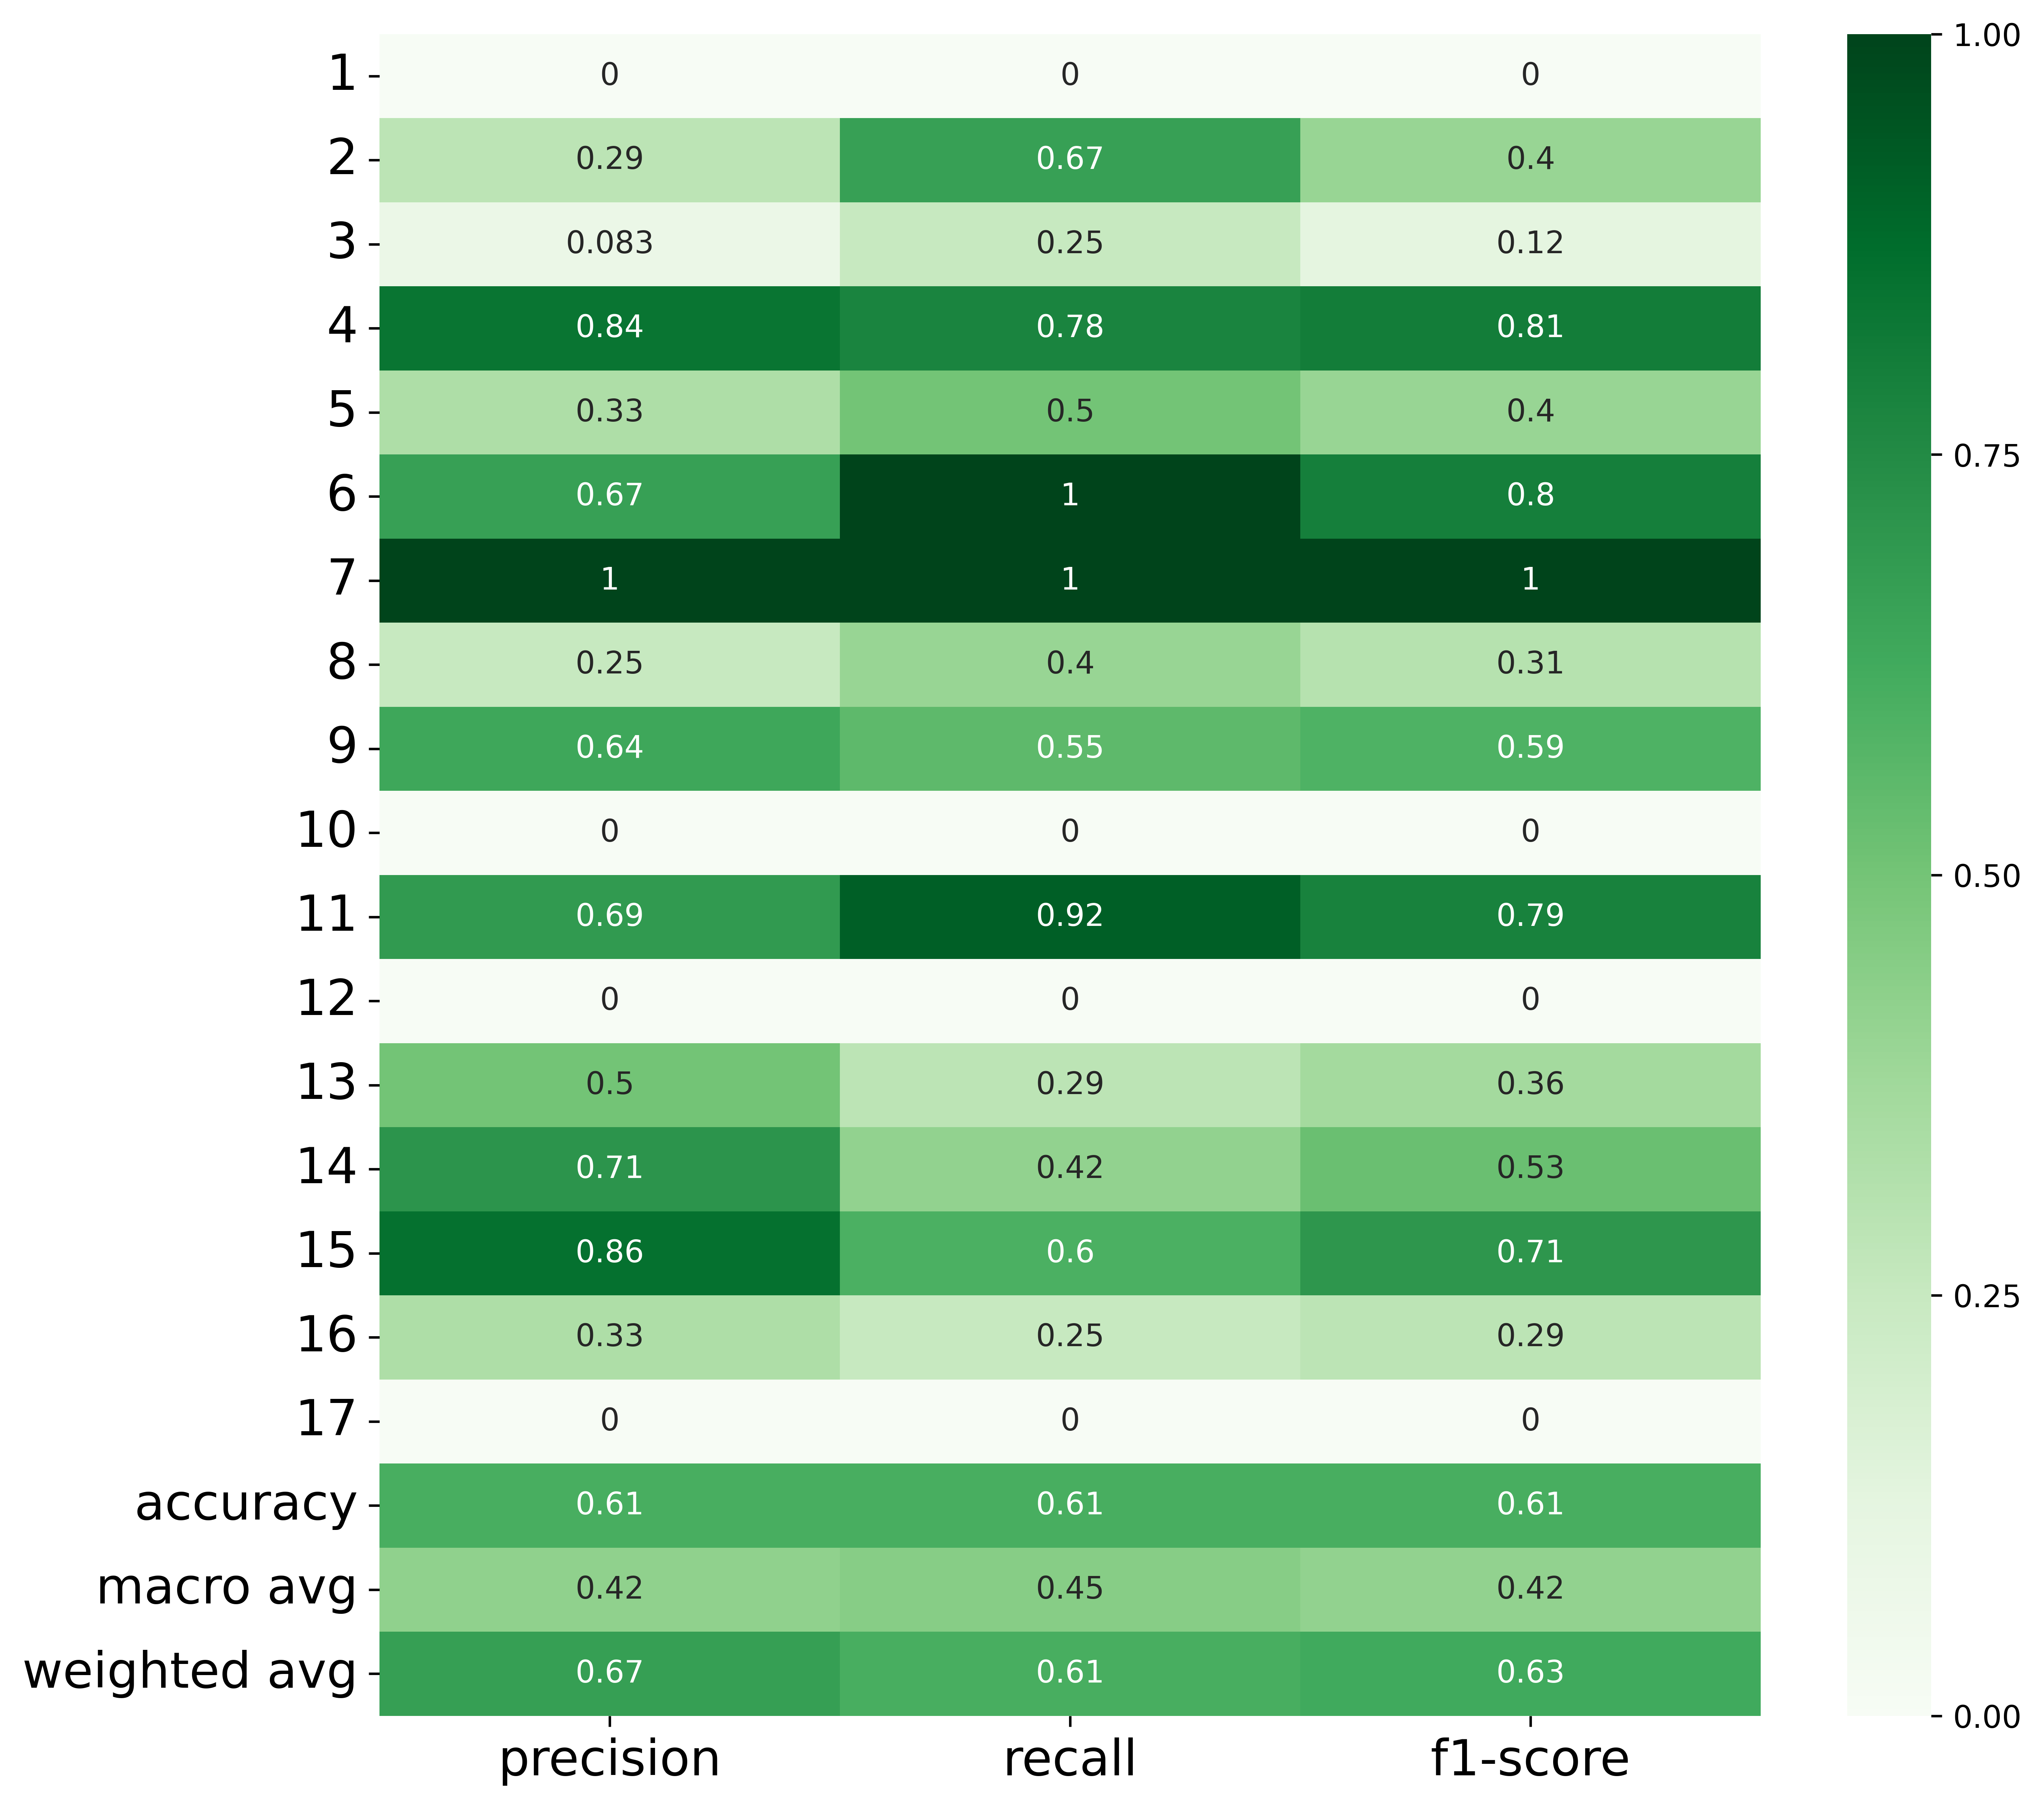

In [18]:
plt.figure(figsize=(10, 10), dpi=600)
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)

clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :].T

# comment to change mapping
#clf_map = list(sdg_map.values()) + ['accuracy', 'macro avg', 'weighted avg']
#clf_report_df.index = clf_map

sns.heatmap(clf_report_df, annot=True, cmap='Greens')
sns.set(font_scale=5);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.tick_params(bottom=True, left=True)
#plt.title('Classification Report');

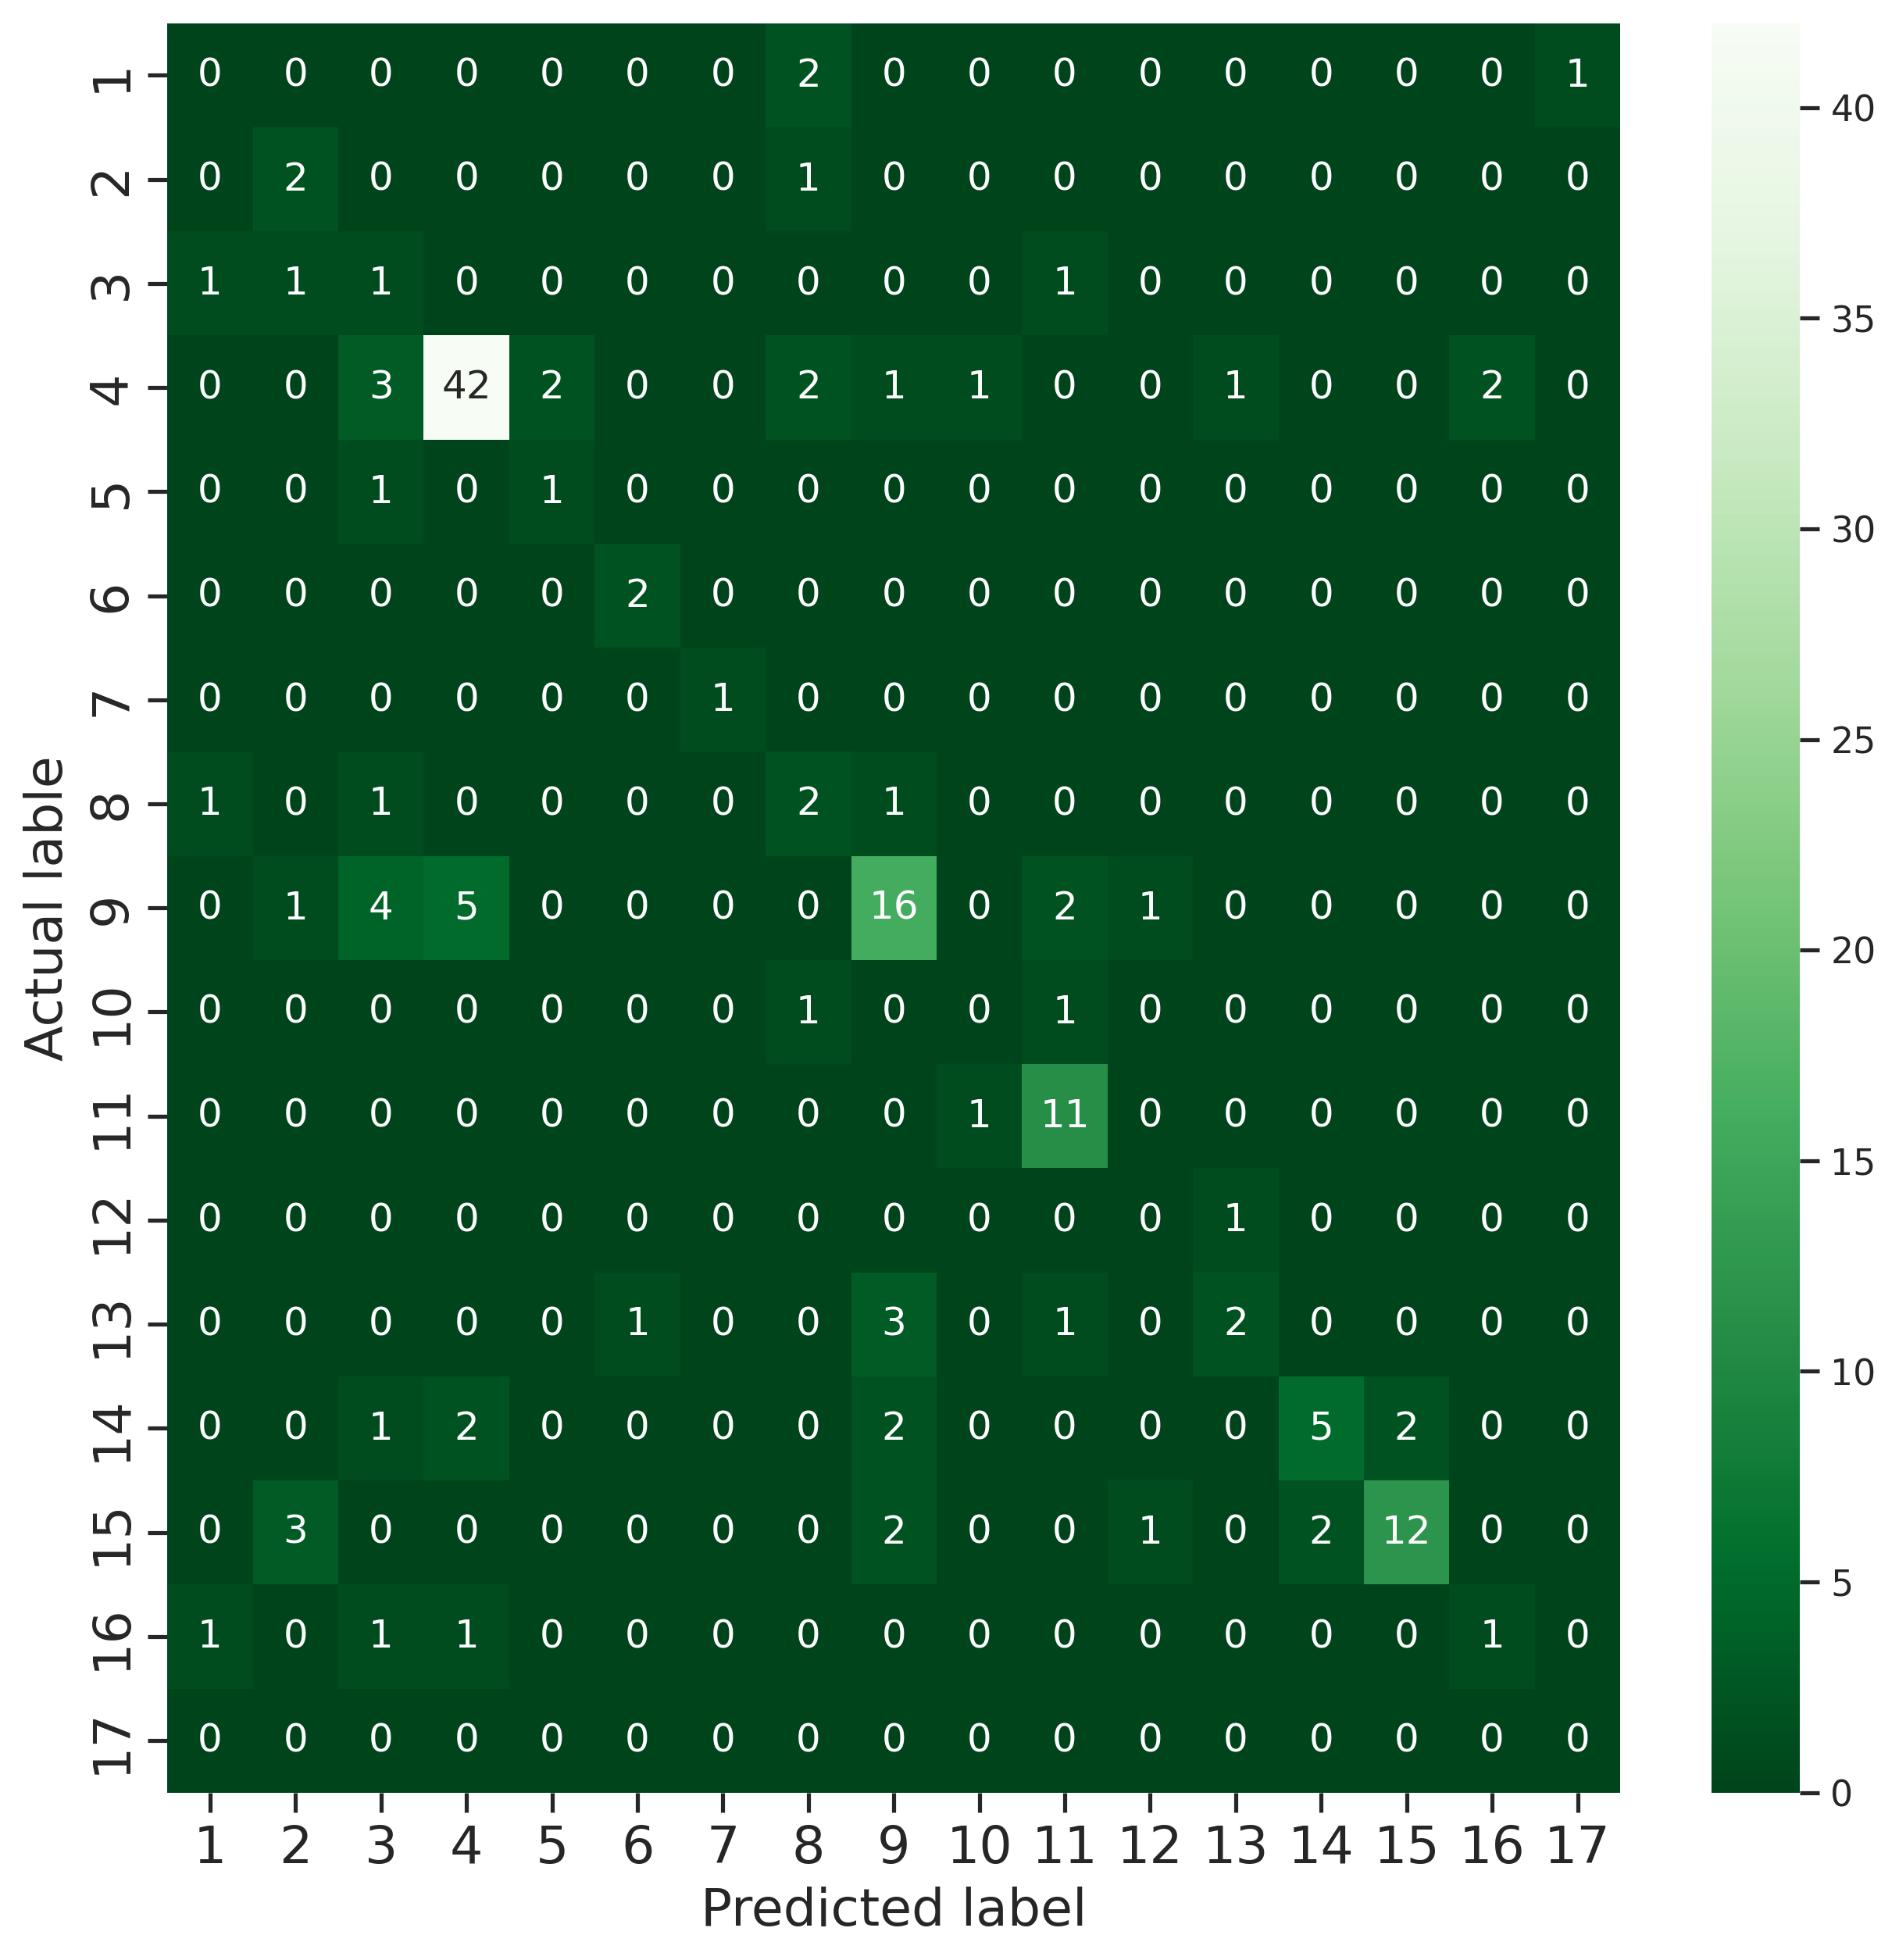

In [21]:
plt.figure(figsize=(10, 10), dpi=300)
cf_matrix = confusion_matrix(model.predict(X_test), y_test)

cf_df = pd.DataFrame(cf_matrix)

cf_map = list(sdg_map.keys())
cf_df.columns = [col for col in cf_map]
cf_df.index = [col for col in cf_map]

sns.heatmap(cf_df, annot=True, cmap='Greens_r')
sns.set(font_scale=1);
#plt.title('Confusion Matrix')
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('Actual lable', fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.tick_params(bottom=True, left=True)

In [23]:
pred_df = pd.read_excel('research_profile_updated.xlsx')
pred_df = pred_df[['Research Title', 'Abstract', 'Keywords', 'SDG']].copy()
pred_df.columns = ['title', 'abstract', 'keywords', 'sdg']


pred_df['keywords'].fillna("", inplace=True)
pred_df['abstract'].fillna("", inplace=True)

# create corpus
pred_df['corpus'] = None
for idx in pred_df.index:
    try:
        pred_df['corpus'].loc[idx] = (pred_df['title'].loc[idx] + pred_df['abstract'].loc[idx] + pred_df['keywords'].loc[idx])
    except:
        continue

        
pred_df['sdg_type'] = pred_df['sdg'].apply(lambda x: type(x))

for idx in pred_df[pred_df['sdg_type'] == str].index:
    multi_label = [int(i) for i in pred_df['sdg'].loc[idx].split(';')]
    label_counts = [pred_df['sdg'].value_counts().loc[label] for label in multi_label]
    pred_df['sdg'].loc[idx] = multi_label[np.argmin(label_counts)]

In [24]:
pred_df['sdg_type'].value_counts()

<class 'int'>    1264
<class 'str'>      15
Name: sdg_type, dtype: int64

In [26]:
class_df = pred_df.groupby(['sdg'], as_index=False).agg({'corpus': ' '.join})
class_df['sdg'] = class_df['sdg'].apply(lambda x: sdg_map[x])

count_vectorizer = CountVectorizer(token_pattern=r'[a-z-]+', stop_words='english', ngram_range=(2, 5)).fit(class_df.corpus)
count = count_vectorizer.transform(class_df.corpus)
words = count_vectorizer.get_feature_names()

ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(pred_df)).toarray()
words_per_class = {label: [words[idx2] for idx2 in ctfidf[idx1].argsort()[-10:]] for idx1, label in enumerate(class_df.sdg)}

sdg_topics = pd.DataFrame()
sdg_topics['SDG'] = words_per_class.keys()
sdg_topics['Topics'] = words_per_class.values()

sdg_topics['Topics'] = sdg_topics['Topics'].apply(lambda x: ((" ".join(x))))

In [27]:
words_per_class

{'No Poverty': ['heavy rainfall areas',
  'ip community',
  'coastal sitios',
  'focus group',
  'national police',
  'rubber heavy',
  'rubber heavy rainfall',
  'group discussion',
  'focus group discussion',
  'heavy rainfall'],
 'Zero Hunger': ['banana peel',
  'foliar fertilizer',
  'rice variety',
  'growth yield',
  'golden apple',
  'golden apple snail',
  'growth performance',
  'apple snail',
  'food products',
  'rice varieties'],
 'Good Health and Well-being': ['sports drink',
  'level awareness',
  'protective mask',
  'solid waste',
  'solid waste management',
  'san ildefonso',
  'general hospital',
  'physical activity',
  'state university',
  'waste management'],
 'Quality Education': ['state institute',
  'pre-service teachers',
  'senior high school',
  'teacher education',
  'flexible learning',
  'senior high',
  'state university',
  'academic performance',
  'higher education',
  'high school'],
 'Gender Equality': ['martial arts',
  'tribal games itg',
  'work 

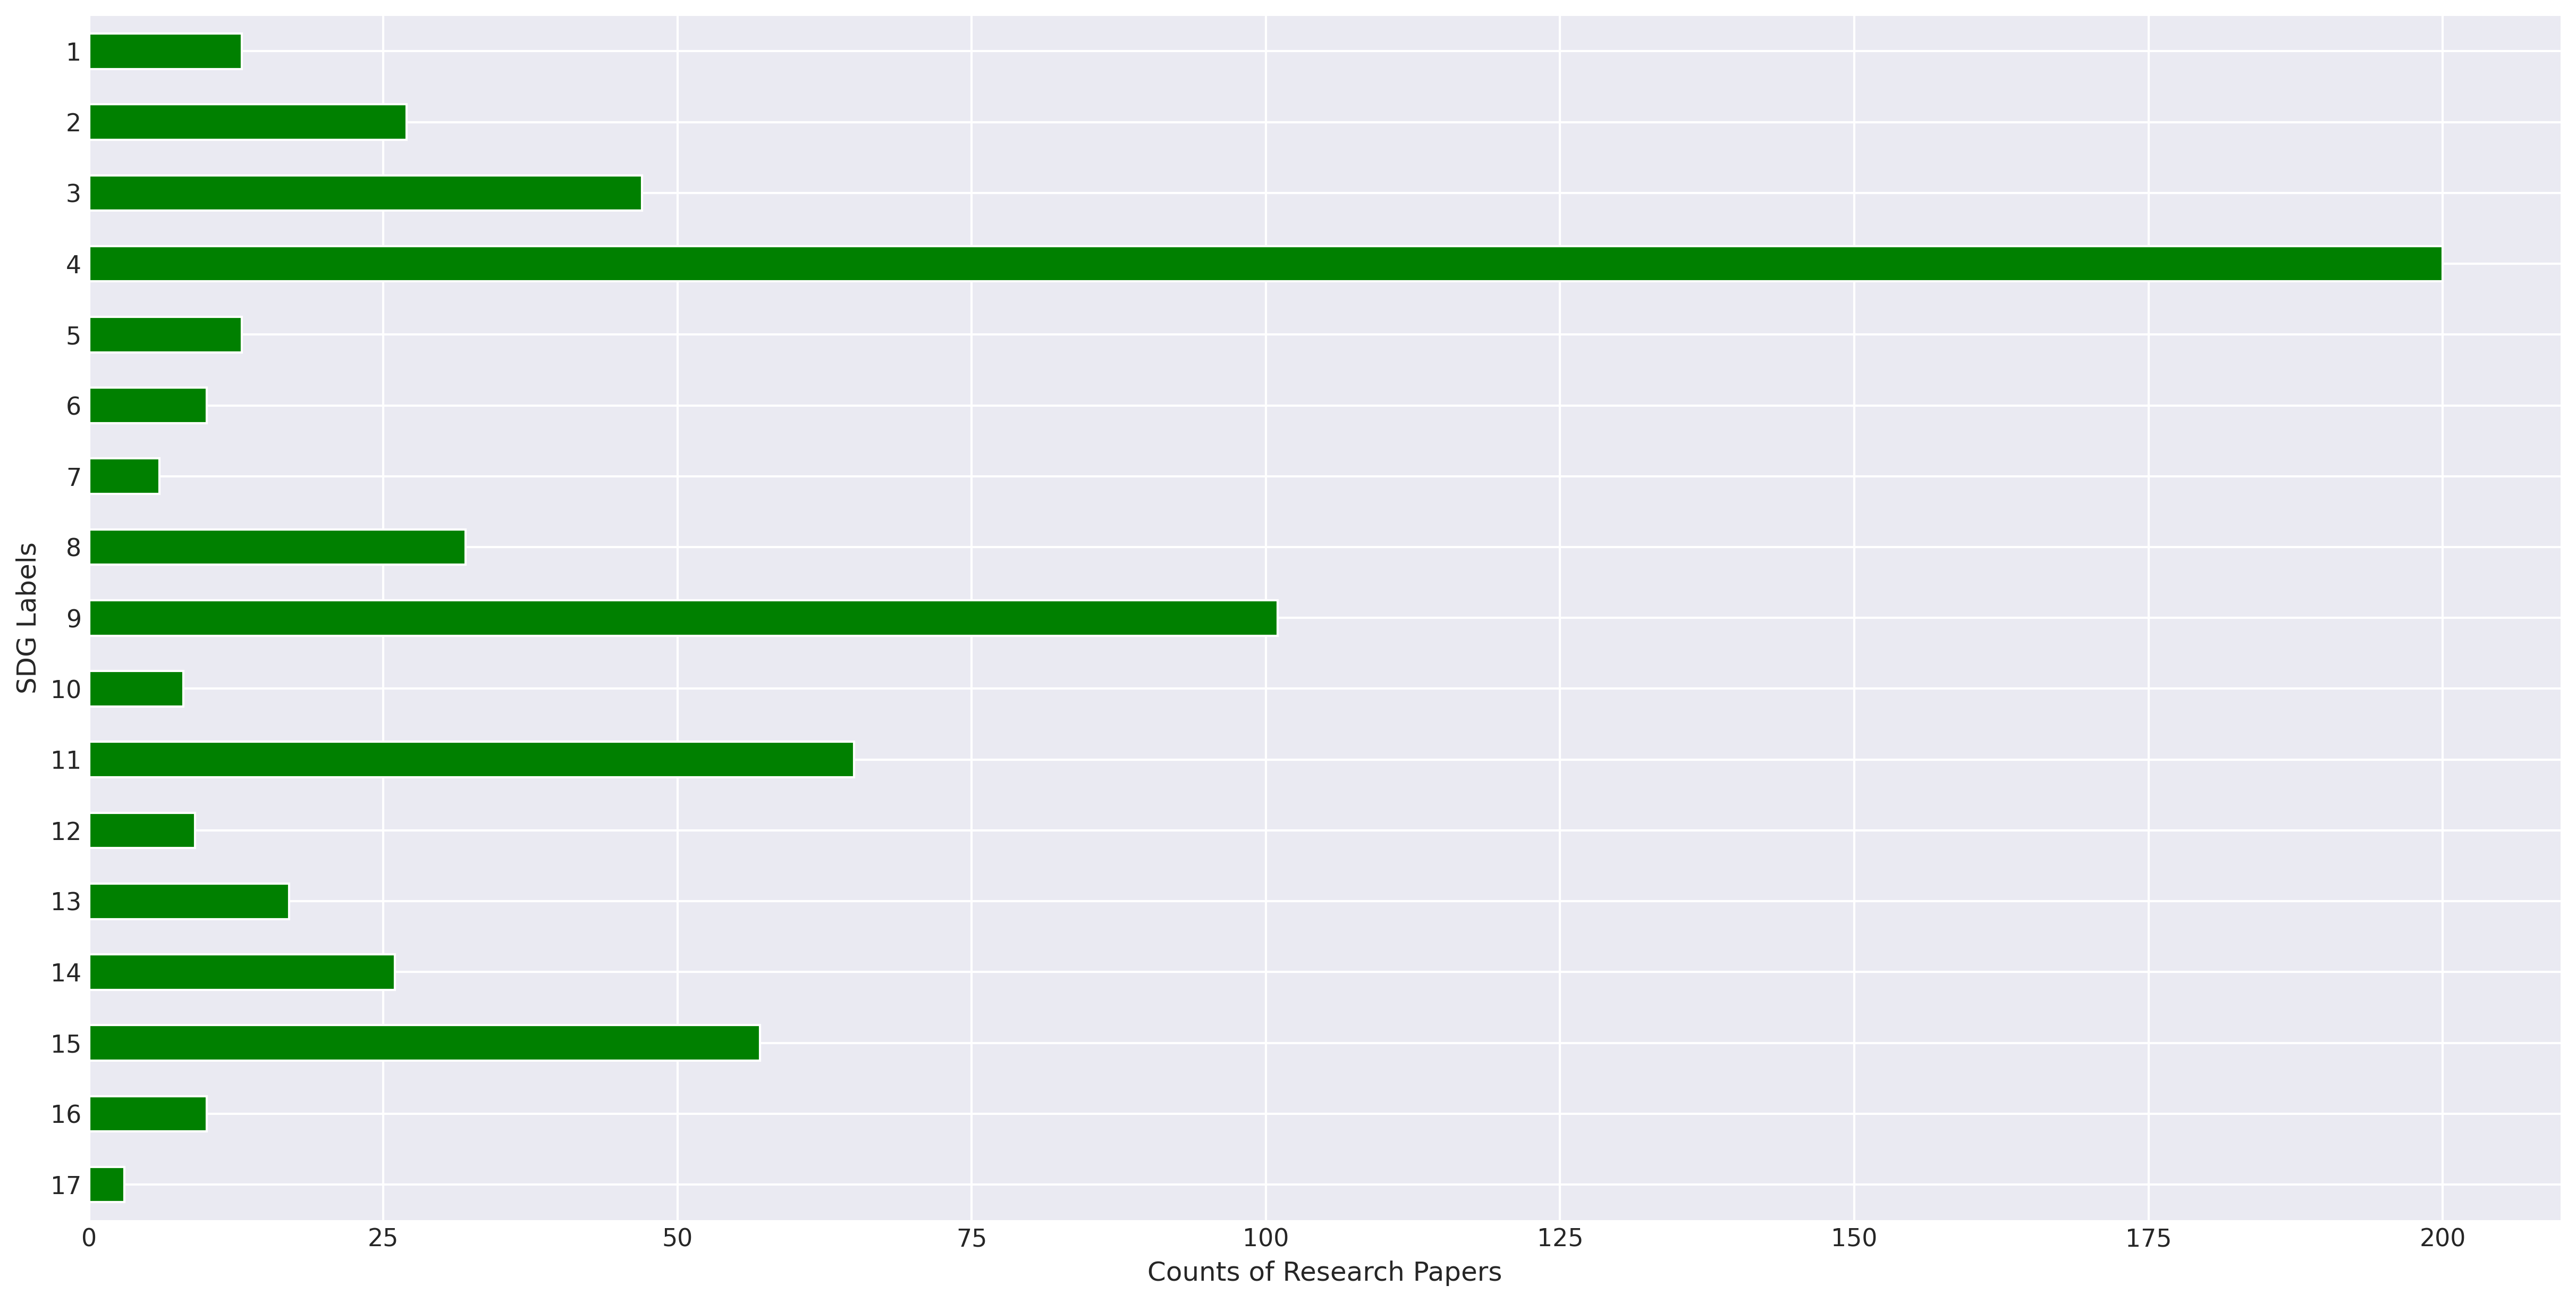

In [28]:
plt.figure(figsize=(20,10), dpi=300)
plt.tick_params(axis='both', which='both', length=0)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.bottom.set_visible(False)
plt.xlabel('Counts of Research Papers')
plt.ylabel('SDG Labels')
sdg_df['sdg'].value_counts().sort_index(ascending=False).plot.barh(color='green');